In [26]:

import itertools
from typing import Any, Callable
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from maze_dataset import MazeDataset, MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators

Testing percolation vals for config 1/2 'g2':   0%|          | 0/16 [00:00<?, ?it/s]

Testing percolation vals for config 2/2 'g4': 100%|██████████| 16/16 [00:00<00:00, 31.28it/s]


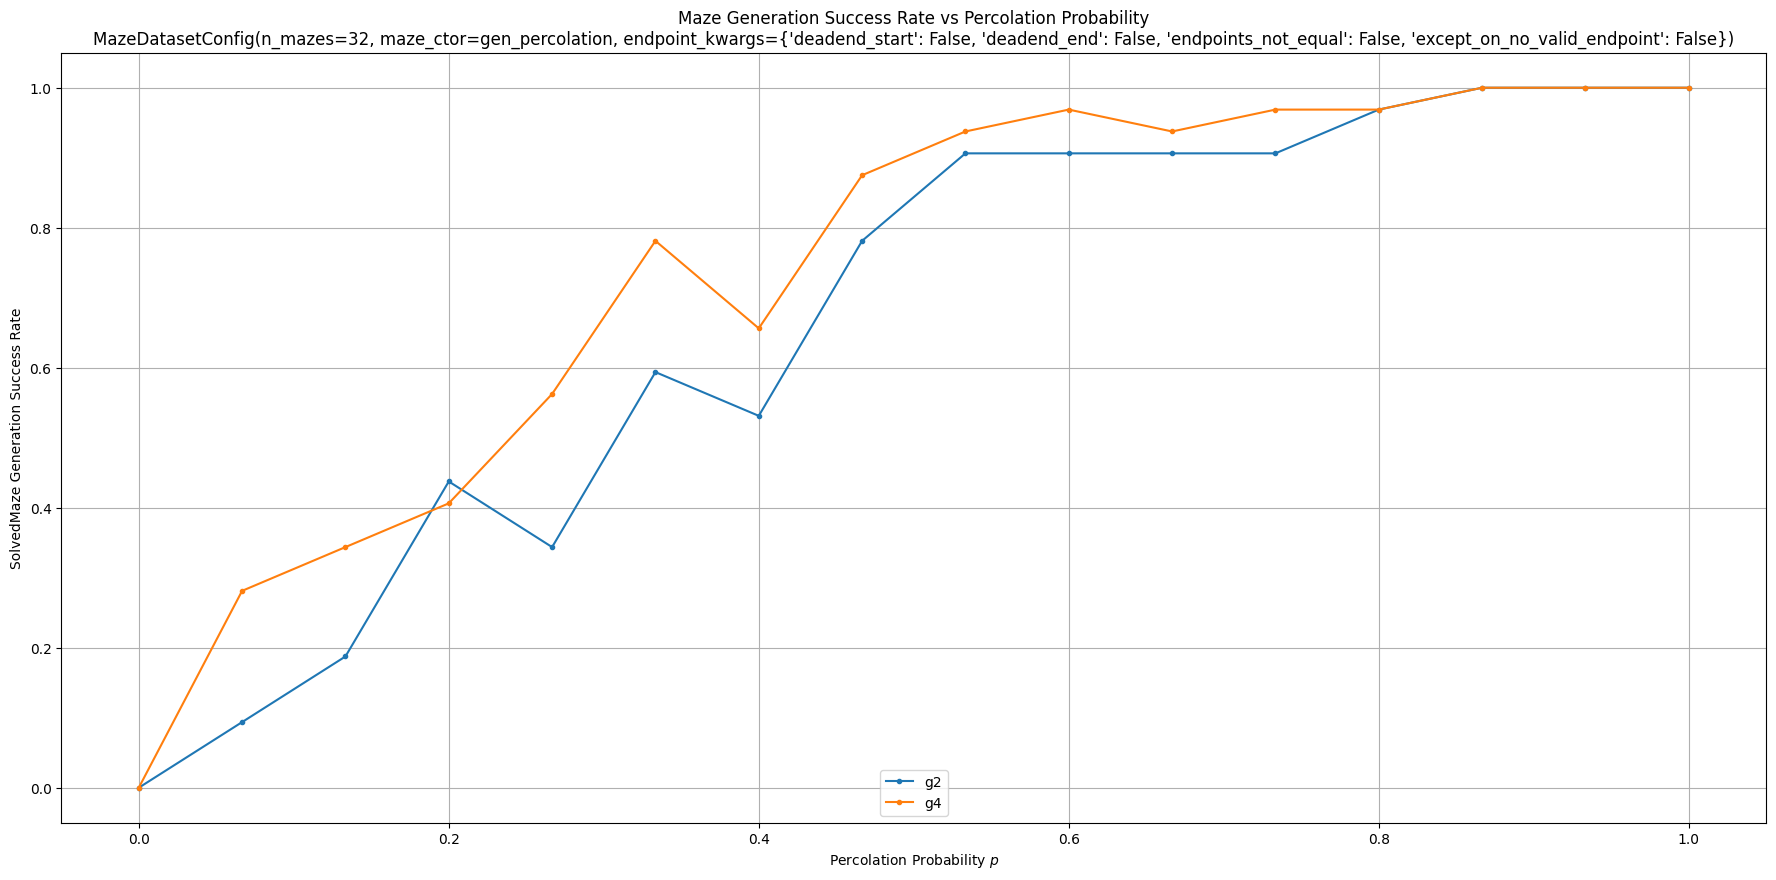

In [23]:


def analyze_percolation_success(
    configs: list[MazeDatasetConfig],
    p_values: np.ndarray,
) -> dict[str, Any]:
    """Analyze success rate of maze generation for different percolation values
    
    # Parameters:
     - `configs : list[MazeDatasetConfig]`
       configs to try
     - `p_values : np.ndarray`   
       numpy array of percolation probability values to test
    
    # Returns:
    `dict[str, Any]` with the following:
    - `"configs": list[MazeDatasetConfig]`
       List of MazeDatasetConfig objects used for testing
    - `"p_values": np.ndarray`
    - `"results": dict[str, np.ndarray]` 
       Dictionary mapping config names to arrays of success rates
    """    

    success_rates: dict[str, np.ndarray] = {}

    for idx_cfg, cfg in enumerate(configs):
        rates: list[float] = []
        for p in tqdm(p_values, desc=f"Testing percolation vals for config {idx_cfg+1}/{len(configs)} '{cfg.name}'", total=len(p_values)):
            cfg_dict: dict = cfg.serialize()
            cfg_dict["maze_ctor_kwargs"]["p"] = float(p)
            cfg_test: MazeDatasetConfig = MazeDatasetConfig.load(cfg_dict)

            dataset: MazeDataset = MazeDataset.from_config(
                cfg_test,
                do_download=False,
                load_local=False,
                save_local=False,
                verbose=False,
            )

            rates.append(len(dataset) / cfg_test.n_mazes)

        success_rates[cfg_test.name] = np.array(rates)

    return dict(configs=configs, p_values=p_values, success_rates=success_rates)


def plot_percolation_results(
    results: dict[str, Any],
    save_path: str = None,
    cfg_keys: list[str]|None = None,
) -> None:
    """Plot the results of percolation analysis.
    
    # Parameters:
     - `results : dict[str, Any]`   
       results dict from `analyze_percolation_success`
     - `save_path : str`   
       Path to save the plot to, will display if `None`
       (defaults to `None`)
    """
    fig: plt.Figure; ax: plt.Axes
    fig, ax = plt.subplots(1, 1, figsize=(22, 10))

    for ep_cfg_name, success_rates in results["success_rates"].items():
        ax.plot(results["p_values"], success_rates, ".-", label=ep_cfg_name)

    ax.set_xlabel("Percolation Probability $p$")
    ax.set_ylabel("SolvedMaze Generation Success Rate")
    cfg: MazeDatasetConfig = results["configs"][0]
    ax.set_title(
        "Maze Generation Success Rate vs Percolation Probability\n"
        + (
            repr(cfg) if cfg_keys is None else (
                "MazeDatasetConfig("
                + ", ".join([
                    f"{k}={getattr(cfg, k).__name__}" if isinstance(getattr(cfg, k), Callable) else f"{k}={getattr(cfg, k)}"
                    for k in cfg_keys
                ])
                + ")"
            )
        )
    )
    ax.grid(True)
    ax.legend(loc="lower center")

    if save_path:
        plt.savefig(save_path)
    plt.show()


# Run the analysis
results: dict[str, Any] = analyze_percolation_success(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            )
        )
        for grid_n in [2, 4]
    ],
    p_values=np.linspace(0.0, 1.0, 16),
)

# Plot results
plot_percolation_results(results, save_path=None, cfg_keys=["n_mazes", "maze_ctor", "endpoint_kwargs"])



# Analyzing 0/6: endpoint_kwargs 'any', gen_func=gen_percolation




Testing percolation vals for config 2/2 'g4': 100%|██████████| 16/16 [00:00<00:00, 32.92it/s]


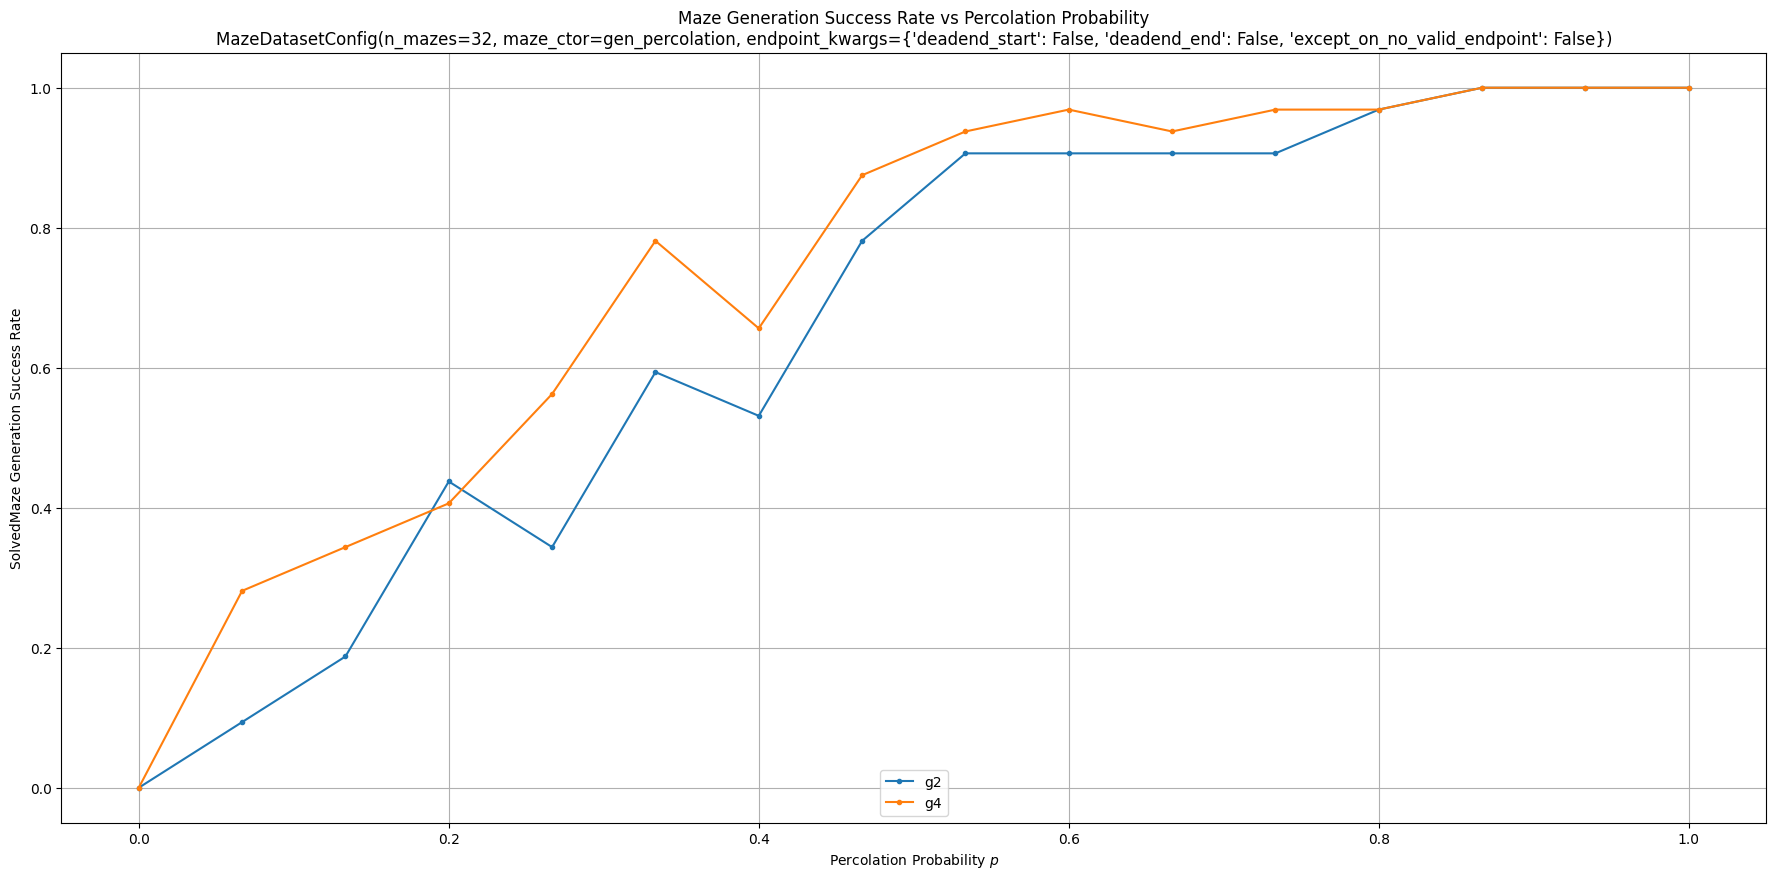



# Analyzing 1/6: endpoint_kwargs 'any', gen_func=gen_dfs_percolation




Testing percolation vals for config 2/2 'g4': 100%|██████████| 16/16 [00:01<00:00, 15.27it/s]


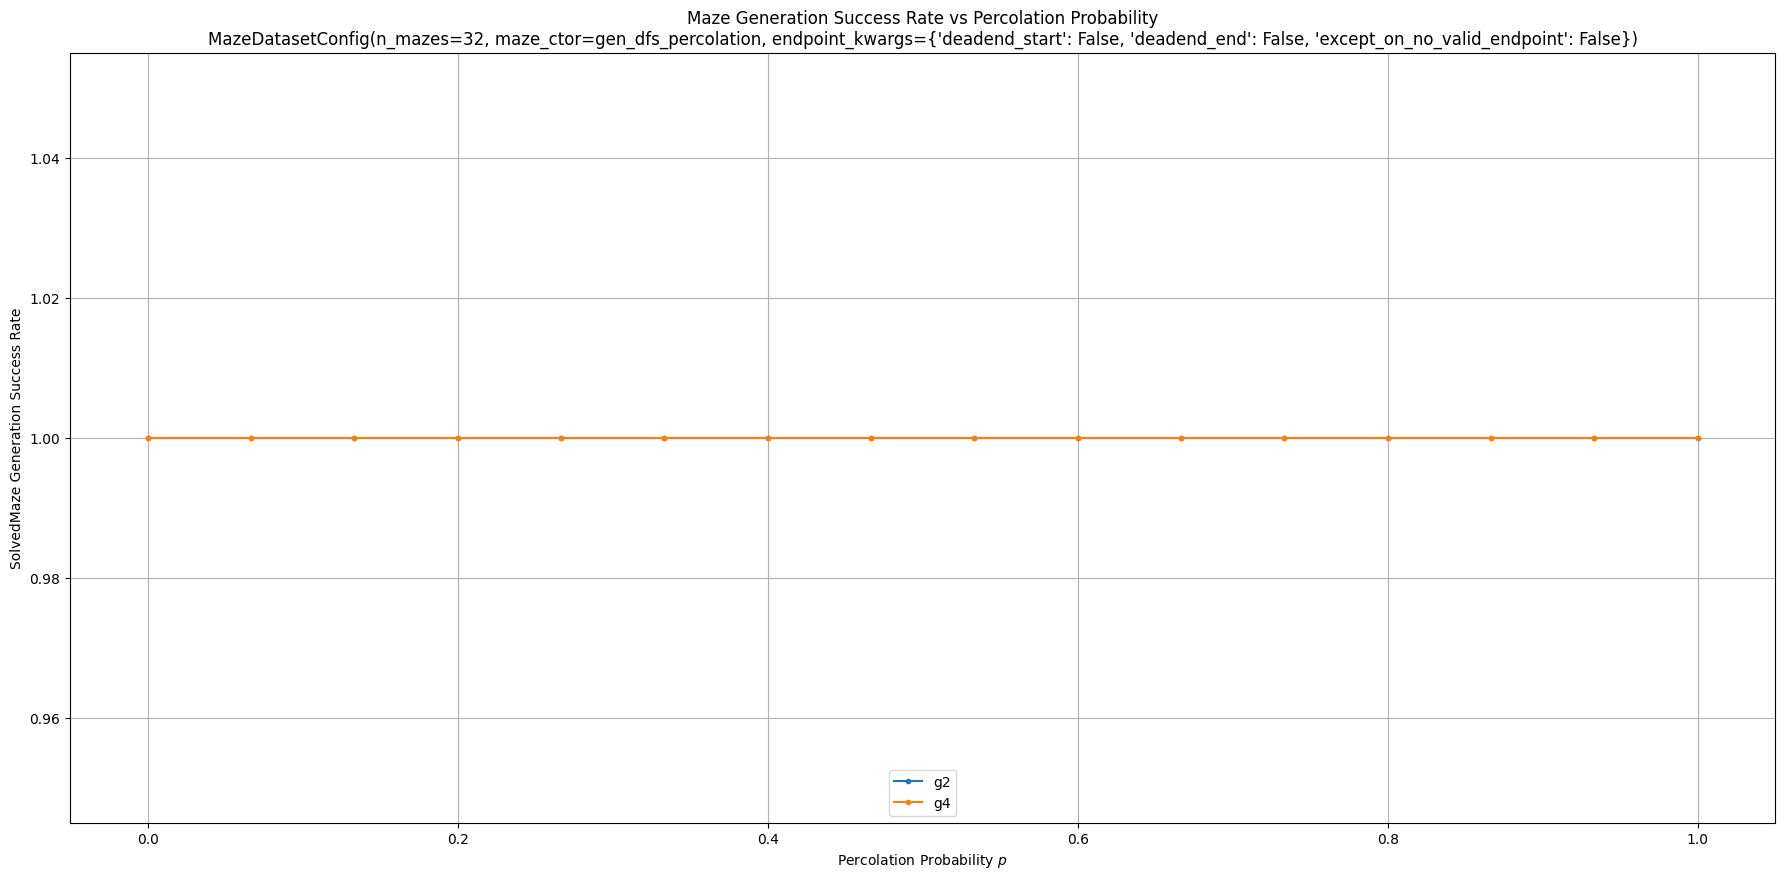



# Analyzing 2/6: endpoint_kwargs 'deadends', gen_func=gen_percolation




Testing percolation vals for config 2/2 'g4': 100%|██████████| 16/16 [00:00<00:00, 17.69it/s]


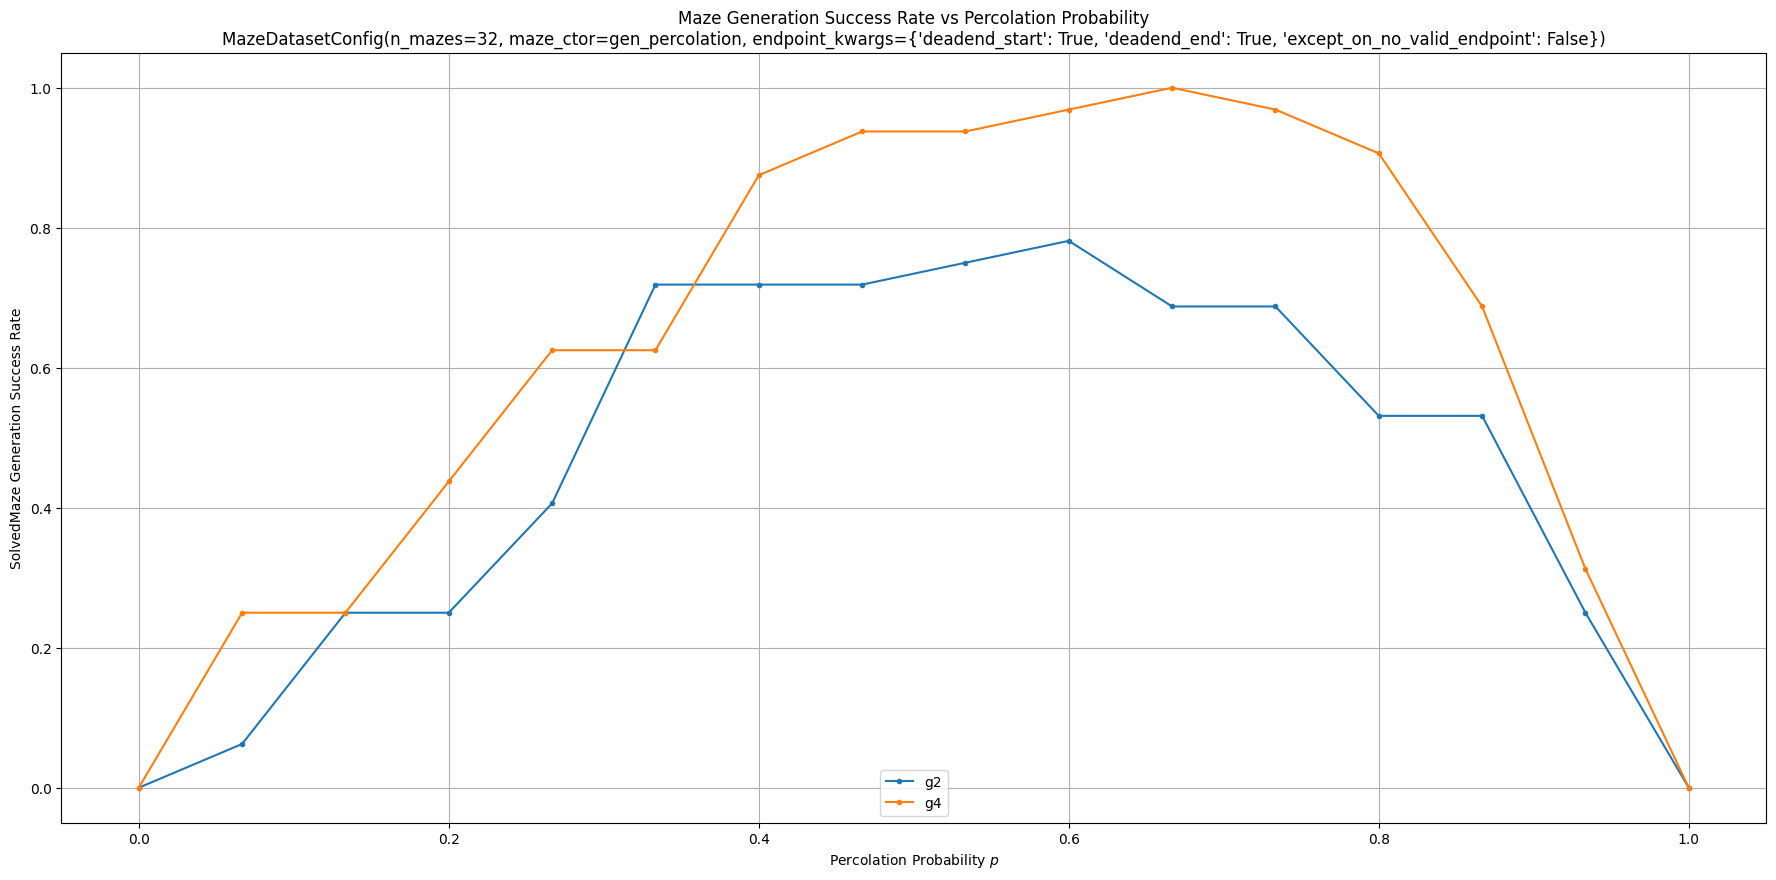



# Analyzing 3/6: endpoint_kwargs 'deadends', gen_func=gen_dfs_percolation




Testing percolation vals for config 2/2 'g4': 100%|██████████| 16/16 [00:01<00:00,  9.76it/s]


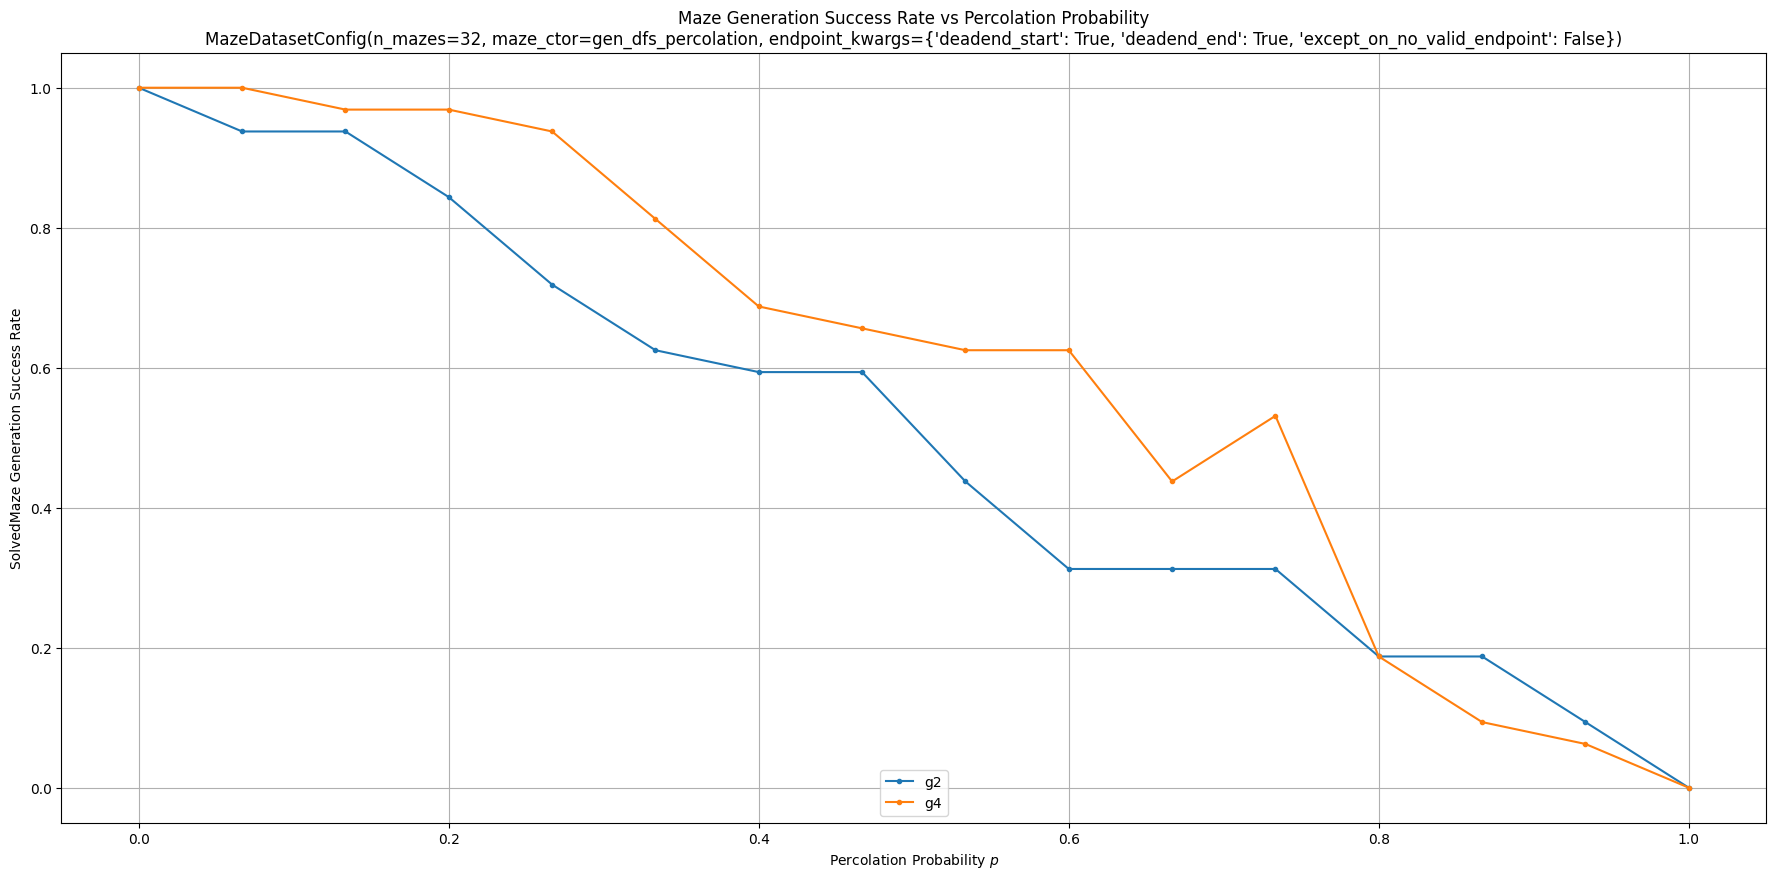



# Analyzing 4/6: endpoint_kwargs 'deadends_unique', gen_func=gen_percolation




Testing percolation vals for config 2/2 'g4': 100%|██████████| 16/16 [00:00<00:00, 19.62it/s]


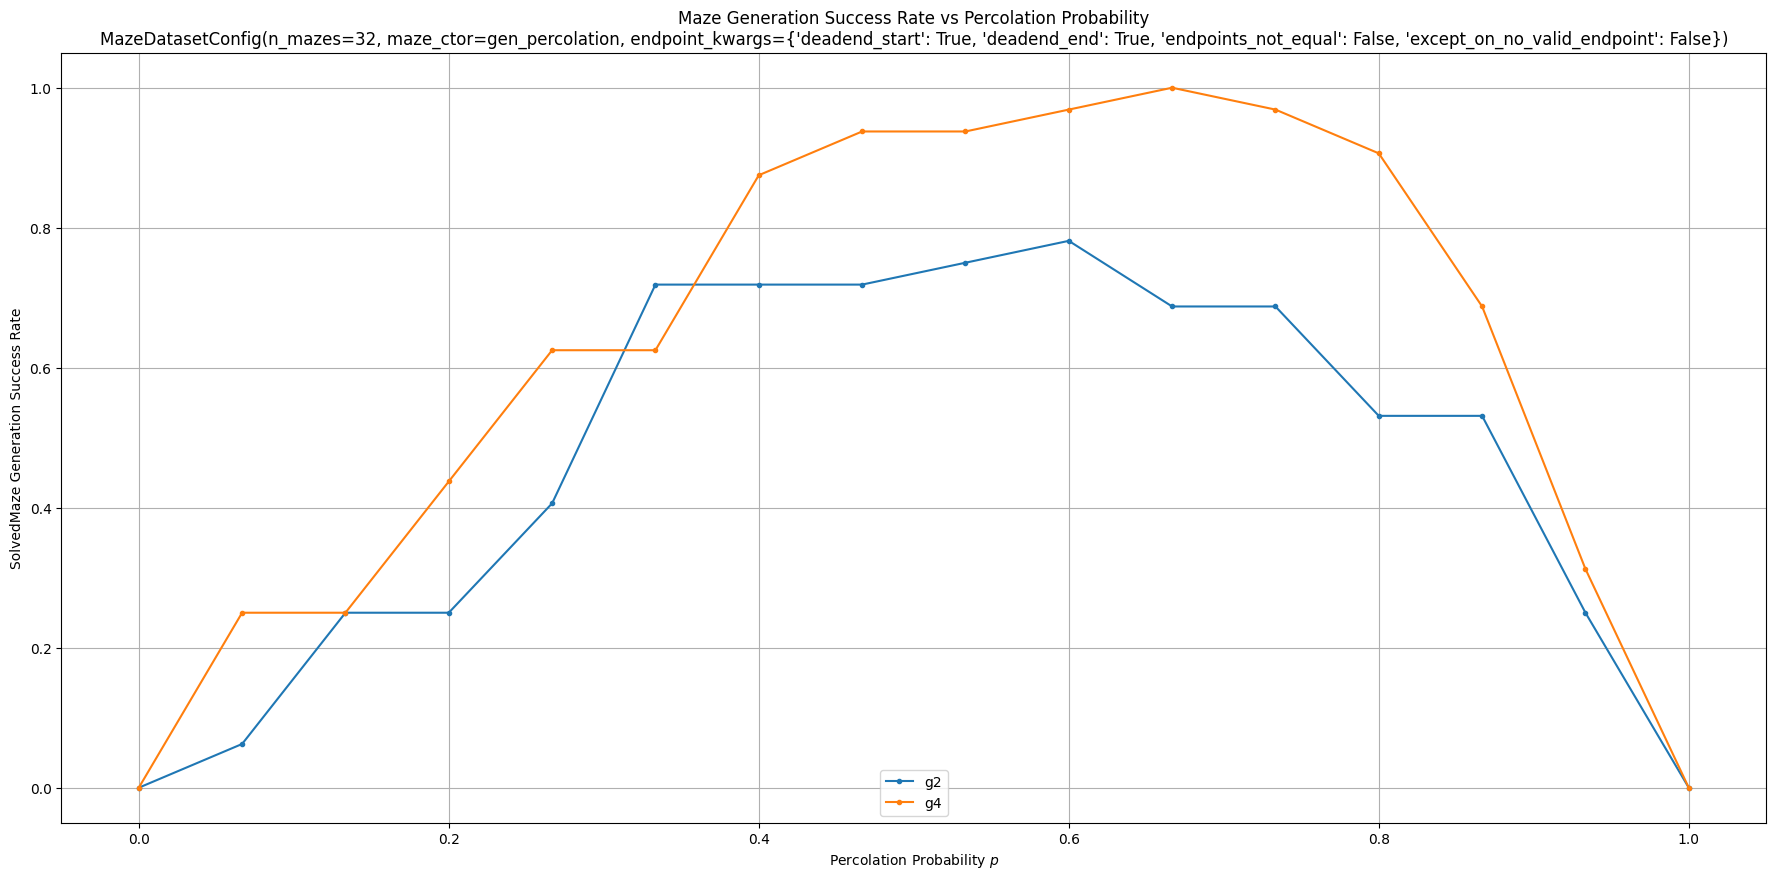



# Analyzing 5/6: endpoint_kwargs 'deadends_unique', gen_func=gen_dfs_percolation




Testing percolation vals for config 2/2 'g4': 100%|██████████| 16/16 [00:01<00:00,  9.36it/s]


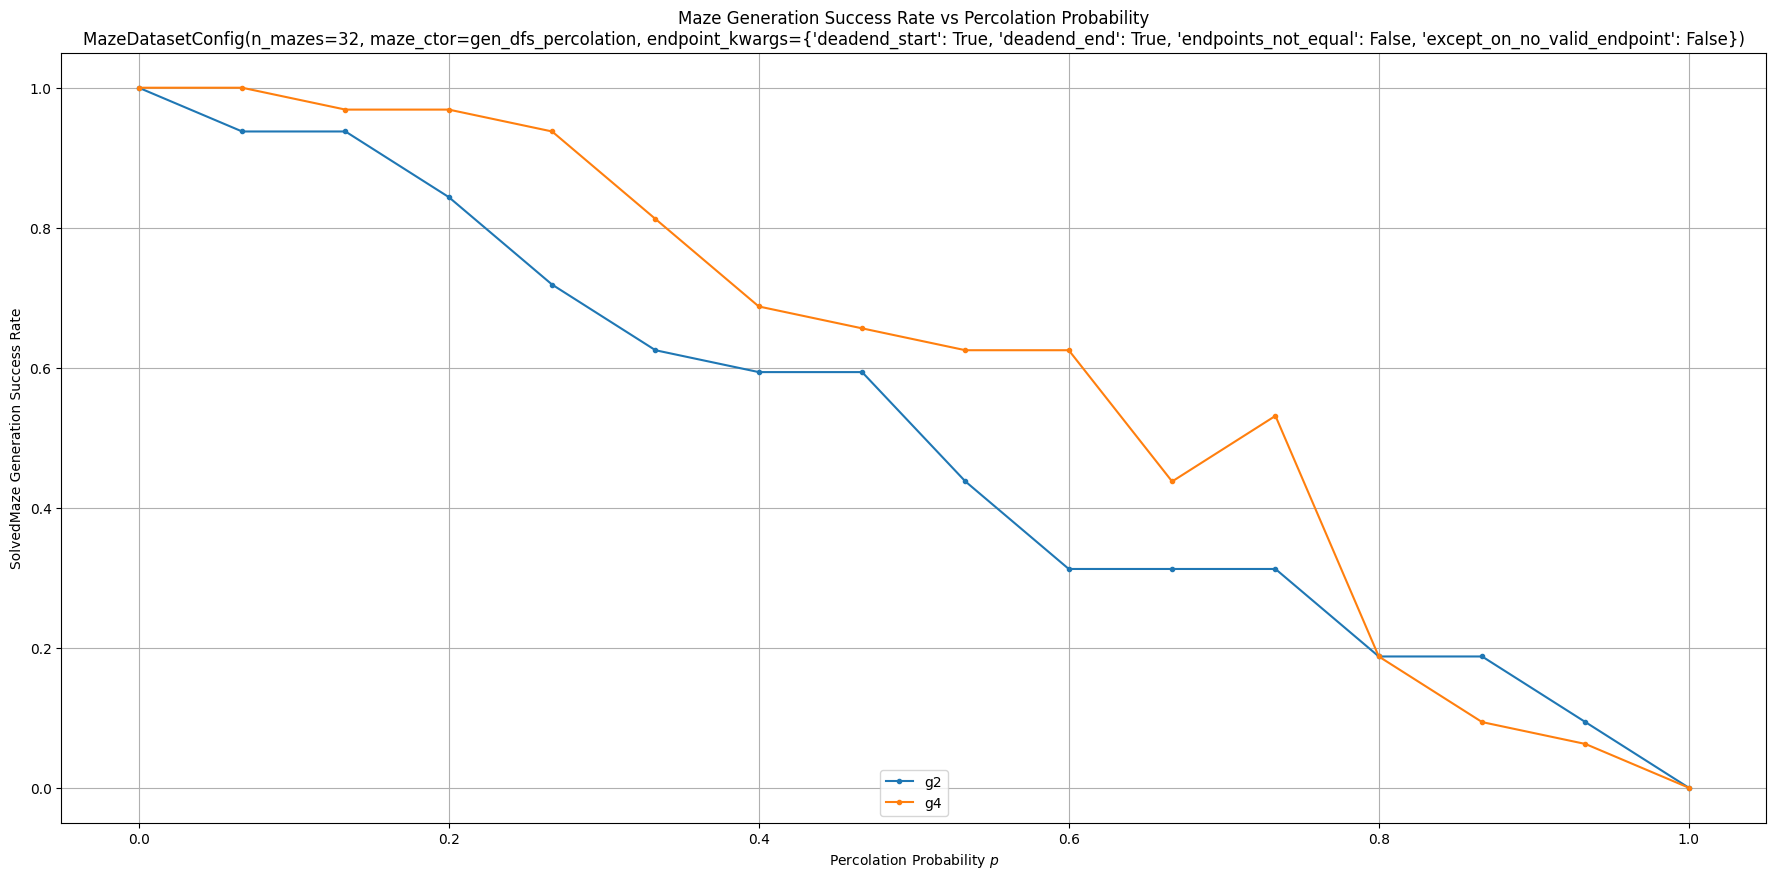

In [30]:
def full_analysis(
	n_mazes: int,
	p_val_count: int,
	grid_sizes: list[int],
	ep_kwargs: list[tuple[str, dict]]|None = None,
	save_dir: Path = Path("../docs/benchmarks/percolation_fractions"),
) -> None:
	
	if ep_kwargs is None:
		ep_kwargs = [
			("any", dict(deadend_start=False, deadend_end=False, except_on_no_valid_endpoint=False)),
			("deadends", dict(deadend_start=True, deadend_end=True, except_on_no_valid_endpoint=False)),
			("deadends_unique", dict(deadend_start=True, deadend_end=True, endpoints_not_equal=False, except_on_no_valid_endpoint=False)),
		]

	cfg_augment_product: list = list(itertools.product(
		ep_kwargs,
		[LatticeMazeGenerators.gen_percolation, LatticeMazeGenerators.gen_dfs_percolation],
	))

	for i, ((ep_kw_name, ep_kw), gen_func) in enumerate(cfg_augment_product):
		print(f"\n\n# Analyzing {i}/{len(cfg_augment_product)}: endpoint_kwargs '{ep_kw_name}', gen_func={gen_func.__name__}\n\n")
		plot_percolation_results(
			analyze_percolation_success(
				configs=[
					MazeDatasetConfig(
						name=f"g{grid_n}",
						grid_n=grid_n,
						n_mazes=n_mazes,
						maze_ctor=gen_func,
						maze_ctor_kwargs=dict(),
						endpoint_kwargs=ep_kw,
					)
					for grid_n in grid_sizes
				],
				p_values=np.linspace(0.0, 1.0, p_val_count),
			),
			save_path = save_dir / f"a_{gen_func.__name__}-ep_{ep_kw_name}.svg",
			cfg_keys=["n_mazes", "maze_ctor", "endpoint_kwargs"],
		)

full_analysis(
	n_mazes=32,
	p_val_count=16,
	grid_sizes=[2, 4],
)